In [1]:
from src.models import *

# New dataset with added concepts

## The added concepts are:

- Intersection Points: Some digits have points where lines intersect (like '4', '8', '9',
'0'), while others do not ('1', '2', '3', '5', '7'). This can be an interesting feature,
labeled as "HasIntersection" or "NoIntersection".


- Closed Loops: Certain digits contain closed loops (e.g., '6', '8', '9', '0'), while others
do not. This could be a feature, labeled as "ClosedLoop:present" or
"ClosedLoop:absent".


- Presence of Horizontal/Vertical Lines: In addition to straight and curved lines,
identifying the presence of specifically horizontal or vertical lines could be useful.
For instance, '1', '4', '7' often have vertical lines, while '2', '5' have horizontal
components.


- Top/Bottom Heavy: Some digits have more weight at the top (like '9') or bottom
(like '6'). This could be an interesting feature to capture, labeled as "TopHeavy" or
"BottomHeavy".

In [6]:
from mimetypes import init
from pyexpat import model
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

import matplotlib.pyplot as plt
import random
import pdb
import argparse

device = "cuda" if torch.cuda.is_available() else "cpu"
class MNISTDatasetWithConcepts(Dataset):
	def __init__(self,split,num_classes,transform):
		isTrain = False
		if split == "train":
			isTrain=True
		self.device = "cuda" if torch.cuda.is_available() else "cpu"
		self.data = MNIST(root = "./synthetic_datasets",train=isTrain, download=True)
		self.num_classes = num_classes
		self.transform = transform
		# print(len(set([self.data[i][1] for i in range(len(self.data))])))

	def __len__(self):
		return len(self.data)

	def __getitem__(self,idx):
		img,label = self.data[idx][0],self.data[idx][1]
		onehot = torch.zeros((self.num_classes,))
		onehot[label] =1
		concept = self.make_concepts_mnist(label)
		label = onehot.to(self.device)
		return [self.transform(img).to(self.device),label,concept]

	def make_concepts_mnist(self,label):
		if label == 0:
			hard_label = torch.tensor([1,0,0,0,0,0,0,0,0,0]+[1,0,0,1,0,0,0,0])
		elif label == 1:
			hard_label = torch.tensor([0,1,0,0,0,0,0,0,0,0]+[0,1,0,0,1,1,0,1])
		elif label == 2:
			hard_label = torch.tensor([0,0,1,0,0,0,0,0,0,0]+[1,1,0,0,1,0,0,1])
		elif label == 3:
			hard_label = torch.tensor([0,0,0,1,0,0,0,0,0,0]+[1,0,0,0,0,0,0,0])
		elif label == 4:
			hard_label = torch.tensor([0,0,0,0,1,0,0,0,0,0]+[0,1,1,0,1,1,1,0])
		elif label == 5:
			hard_label = torch.tensor([0,0,0,0,0,1,0,0,0,0]+[1,1,0,0,1,1,1,0])
		elif label == 6:
			hard_label = torch.tensor([0,0,0,0,0,0,1,0,0,0]+[1,0,1,1,0,0,0,1])
		elif label == 7:
			hard_label = torch.tensor([0,0,0,0,0,0,0,1,0,0]+[0,1,0,0,1,0,1,0])
		elif label == 8:
			hard_label = torch.tensor([0,0,0,0,0,0,0,0,1,0]+[1,0,1,1,0,0,1,1])
		elif label == 9:
			hard_label = torch.tensor([0,0,0,0,0,0,0,0,0,1]+[1,0,1,1,0,0,1,0])

		# pdb.set_trace()

		# hard_label = torch.zeros((self.num_classes,))
		# hard_label[label] = 1
		hard_label = hard_label.float().to(self.device)
		return hard_label


def load_mnist_dataloader(split,bsz):
	dataset = MNISTDatasetWithConcepts(split = split, num_classes = 10, transform=ToTensor())
	dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True)
	return dataloader


In [7]:
train_loader = load_mnist_dataloader(split = "train",bsz=64)
test_loader = load_mnist_dataloader(split = "test",bsz=64)

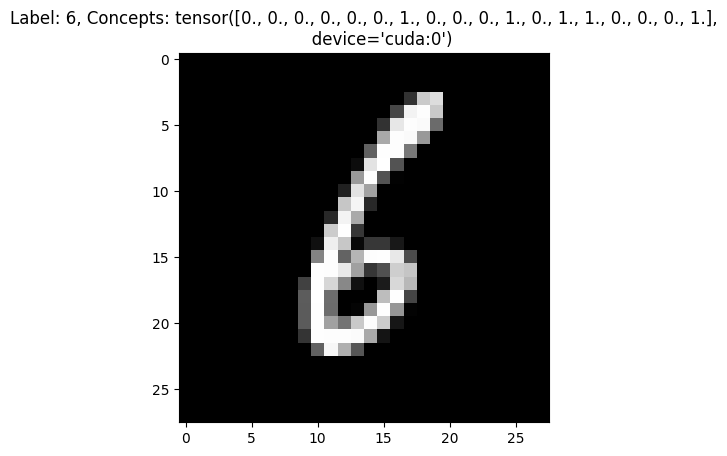

In [4]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
for images, labels, concepts in train_loader:
    img_idx = 7
    image = images[img_idx]
    fig, ax = plt.subplots(1)
    ax.imshow(image.squeeze().cpu(), cmap="gray")
    plt.title(f"Label: {labels[img_idx].argmax()}, Concepts: {concepts[img_idx]}")
    plt.show()
    break

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class g(nn.Module):
    """The network g consists of 2 convolutional
    layers with 32 channels each, along with a maxpool
    layer in between followed by a fully connected
    layer."""

    def __init__(self, n_concepts):
        super(g, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 10+n_concepts*2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        non_overlapping, overlapping = x[:,:10], x[:,10:]
        return non_overlapping, overlapping

class f(nn.Module):
    def __init__(self, input_size) -> None:
        super(f, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def split_concepts(concepts):
    return concepts[:,:10], concepts[:,10:]

In [13]:
class Sequential(nn.Module):
    def __init__(self, n_concepts):
        super(Sequential, self).__init__()
        self.g_model = g(n_concepts).to(device)
        self.f_model = f(10+n_concepts*2).to(device)

        # Defining the training parameters for the concepts model g
        self.g_optimizer = torch.optim.Adam(self.g_model.parameters(), lr=1e-4)
        self.g_criterion = nn.CrossEntropyLoss()

        # Defining the training parameters for the prediction model f
        self.learned_g = False
        self.f_optimizer = torch.optim.Adam(self.f_model.parameters(), lr=1e-4)
        self.f_criterion = nn.CrossEntropyLoss()
        self.name = 'sequential'

    def split_concepts(self, concepts):
        return concepts[:,:10], concepts[:,10:]

    def loss_overlapping(self, overlapping, y_true):
        total_loss = 0
        for i in range(0, overlapping.shape[1], 2):
            loss = self.g_criterion(overlapping[:, i:i+2], y_true[:, int(i/2)].long())
            total_loss += loss

        return total_loss

    def train_g(self, train_loader, epochs):
        self.g_model.train()
        for epoch in range(epochs):
            for images, labels, concepts in train_loader:
                images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
                y_true_non_overlapping, y_true_overlapping = self.split_concepts(concepts)

                self.g_optimizer.zero_grad()
                non_overlapping, overlapping = self.g_model(images)

                # Calculate the loss for non_overlaaping concepts
                loss_non_overlapping = self.g_criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))

                # Calculate the loss for overlapping concepts
                loss_overlapping = self.loss_overlapping(overlapping, y_true_overlapping)
                
                # Calculate the total loss
                loss = loss_non_overlapping + loss_overlapping
                loss.backward()
                self.g_optimizer.step()
            print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")
        self.learned_g = True

    def calc_acc_non_overlapping(self, test_loader):
        self.g_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, _, concepts in test_loader:
                images, concepts = images.to(device), concepts.to(device)
                y_true_non_overlapping, _ = self.split_concepts(concepts)
                non_overlapping, _ = self.g_model(images)
                y_pred_non_overlapping = non_overlapping.argmax(dim=1)
                correct += (y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)).sum().item()
                total += y_true_non_overlapping.size(0)

        return correct / total if total > 0 else 0

    def calc_acc_overlapping(self, test_loader):
        self.g_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, _, concepts in test_loader:
                images, concepts = images.to(device), concepts.to(device)
                _, y_true_overlapping = self.split_concepts(concepts)
                _, overlapping = self.g_model(images)

                for i in range(0, overlapping.shape[1], 2):
                    y_pred_overlapping = overlapping[:, i:i+2].argmax(dim=1)
                    correct += (y_pred_overlapping == y_true_overlapping[:, int(i/2)]).sum().item()
                    total += y_true_overlapping.size(0)

        return correct / total if total > 0 else 0

    def calc_acc_g(self, test_loader):
        self.g_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, _, concepts in test_loader:
                images, concepts = images.to(device), concepts.to(device)
                y_true_non_overlapping, y_true_overlapping = self.split_concepts(concepts)
                non_overlapping, overlapping = self.g_model(images)

                y_pred_non_overlapping = non_overlapping.argmax(dim=1)
                correct += (y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)).sum().item()
                total += y_true_non_overlapping.size(0)

                for i in range(0, overlapping.shape[1], 2):
                    y_pred_overlapping = overlapping[:, i:i+2].argmax(dim=1)
                    correct += (y_pred_overlapping == y_true_overlapping[:, int(i/2)]).sum().item()
                    total += y_true_overlapping.size(0)

        return correct / total if total > 0 else 0
    
    def train_f(self, train_loader, epochs):
        if not self.learned_g:
            raise "You have to train g before training f in sequential training"
        self.f_model.train()
        for epoch in range(epochs):
            for images, labels, _ in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.f_optimizer.zero_grad()

                non_overlapping, overlapping = self.g_model(images)
                # Concatenate the concepts
                overlapping_concat = torch.cat([non_overlapping, overlapping], dim=1)
                y_pred = self.f_model(overlapping_concat)
                loss = self.f_criterion(y_pred, labels.argmax(dim=1))
                loss.backward()
                self.f_optimizer.step()
            print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

    def calc_acc_prediction(self, test_loader, delta=None):
        accuracies = []
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            if delta is not None:
                y_pred = self.forward(images + delta[:images.shape[0]]).argmax(dim=1)
            else:
                y_pred = self.forward(images).argmax(dim=1)
            acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
            accuracies.append(acc)
        return sum(accuracies)/len(accuracies)

    def train(self, train_loader, epochs=20):
        self.train_g(train_loader, epochs)
        self.train_f(train_loader, epochs)
    def forward(self, x):
        non_overlapping, overlapping = self.g_model(x)
        # Concatenate the concepts
        overlapping = torch.cat([non_overlapping, overlapping], dim=1)
        return self.f_model(overlapping)

    def save_g(self):
        torch.save(self.g_model.state_dict(), "g_model1.pth")

    def load_g(self, path):
        self.g_model.load_state_dict(torch.load(path))
        self.learned_g = True

    def save_f(self):
        torch.save(self.f_model.state_dict(), "f_model1.pth")

    def load_f(self, path):
        self.f_model.load_state_dict(torch.load(path))

In [14]:
n_concepts = 8
sequential = Sequential(8)
sequential.train(train_loader, 20)


Epoch: 1, Loss: 1.725
Epoch: 2, Loss: 1.329
Epoch: 3, Loss: 1.445
Epoch: 4, Loss: 0.605
Epoch: 5, Loss: 0.171
Epoch: 6, Loss: 1.510
Epoch: 7, Loss: 0.449
Epoch: 8, Loss: 0.476
Epoch: 9, Loss: 0.129
Epoch: 10, Loss: 0.289
Epoch: 11, Loss: 0.668
Epoch: 12, Loss: 0.155
Epoch: 13, Loss: 0.200
Epoch: 14, Loss: 0.129
Epoch: 15, Loss: 0.076
Epoch: 16, Loss: 0.062
Epoch: 17, Loss: 0.016
Epoch: 18, Loss: 0.350
Epoch: 19, Loss: 0.152
Epoch: 20, Loss: 0.049
Epoch: 1, Loss: 0.254
Epoch: 2, Loss: 0.096
Epoch: 3, Loss: 0.062
Epoch: 4, Loss: 0.061
Epoch: 5, Loss: 0.004
Epoch: 6, Loss: 0.003
Epoch: 7, Loss: 0.002
Epoch: 8, Loss: 0.123
Epoch: 9, Loss: 0.002
Epoch: 10, Loss: 0.011
Epoch: 11, Loss: 0.252
Epoch: 12, Loss: 0.042
Epoch: 13, Loss: 0.014
Epoch: 14, Loss: 0.076
Epoch: 15, Loss: 0.006
Epoch: 16, Loss: 0.019
Epoch: 17, Loss: 0.001
Epoch: 18, Loss: 0.000
Epoch: 19, Loss: 0.020
Epoch: 20, Loss: 0.028


In [15]:
# Saving the joint_model
torch.save(sequential.state_dict(), "./models/sequential model/sequential3.pth")

In [16]:
# testing sequential model

sequential = Sequential(8)
sequential.load_state_dict(torch.load("./models/sequential model/sequential3.pth"))
sequential.calc_acc_prediction(test_loader  )

0.9892515923566879

In [100]:
def pgd_linf_targ(model, data_loader, epsilon, alpha, num_iter, y_targ, example):
    """
      Training on the whole test set
    """
    delta = torch.zeros_like(example, requires_grad=True)
    for t in range(num_iter):
      print(f"Running iteration {t}")
      for X, y, concepts in data_loader:
        X, y, concepts = images.to(device), labels.to(device), concepts.to(device)
        yp = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()


for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break
delta = pgd_linf_targ(sequential, test_loader, epsilon=0.4, alpha=1e-2, num_iter=20, y_targ=2, example=images)
yp = sequential(images + delta)

Running iteration 0


Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19


In [101]:
sequential.calc_acc_prediction(test_loader, delta)

0.09106289808917198

In [102]:
acc_non_overlapping = sequential.calc_acc_non_overlapping(test_loader)
acc_non_overlapping

0.9884

In [103]:
acc_overlapping = sequential.calc_acc_overlapping(test_loader)
acc_overlapping

0.99215

In [104]:
acc_g = sequential.calc_acc_g(test_loader)
acc_g

0.9917333333333334

In [105]:
acc_g

0.9917333333333334

# Joint model

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Joint(nn.Module):
    def __init__(self):
        super(Joint, self).__init__()
        self.g_model = g(n_concepts).to(device)
        self.f_model = f(10+n_concepts*2).to(device)

        self.name = 'joint'

    def forward(self, x):
        non_overlapping, overlapping = self.g_model(x)
        overlapping_concat = torch.cat([non_overlapping, overlapping], dim=1)
        y_pred = self.f_model(overlapping_concat)
        return y_pred, non_overlapping, overlapping
    

    def loss_overlapping(self, overlapping, y_true):
        total_loss = 0
        concept_idx = 0
        # print(overlapping.shape)
        for i in range(0, overlapping.shape[1], 2):
            loss = nn.CrossEntropyLoss()(overlapping[:, i:i+2], y_true[:, concept_idx].long())
            concept_idx += 1
            total_loss += loss

        return total_loss




In [86]:
pred_loss_weight, concepts_loss_weight = 0.5, 1

In [87]:
def calc_loss(model, y_pred, labels, non_overlapping, overlapping, y_true_non_overlapping, y_true_overlapping, criterion, pred_loss_weight, concepts_loss_weight):
    
    # Calculate the loss for non_overlaaping concepts
    loss_non_overlapping = criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))
    # Calculate the loss for overlapping concepts
    # print(overlapping.shape, y_true_overlapping.shape)
    loss_overlapping = model.loss_overlapping(overlapping, y_true_overlapping)
    # Calculate the loss for concepts
    concept_loss = loss_non_overlapping + loss_overlapping

    # Calculate the loss for prediction
    pred_loss = criterion(y_pred, labels.argmax(dim=1))

    loss = pred_loss_weight * pred_loss + concepts_loss_weight * concept_loss
    return loss

def train_joint(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, concepts in train_loader:
            images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
            optimizer.zero_grad()
            y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
            y_pred, non_overlapping, overlapping = model(images)

            loss = calc_loss(model, y_pred, labels, non_overlapping, overlapping, y_true_non_overlapping, y_true_overlapping, criterion, pred_loss_weight, concepts_loss_weight )
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

joint_model = Joint().to(device)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20
train_joint(joint_model, train_loader, epochs, optimizer, criterion)


Epoch: 1, Loss: 2.246
Epoch: 2, Loss: 0.472
Epoch: 3, Loss: 0.715
Epoch: 4, Loss: 0.858
Epoch: 5, Loss: 0.672
Epoch: 6, Loss: 0.188
Epoch: 7, Loss: 0.665
Epoch: 8, Loss: 0.118
Epoch: 9, Loss: 0.241
Epoch: 10, Loss: 0.076
Epoch: 11, Loss: 0.232
Epoch: 12, Loss: 0.317
Epoch: 13, Loss: 0.242
Epoch: 14, Loss: 0.071
Epoch: 15, Loss: 0.524
Epoch: 16, Loss: 0.078
Epoch: 17, Loss: 0.031
Epoch: 18, Loss: 0.063
Epoch: 19, Loss: 0.078
Epoch: 20, Loss: 0.037


In [88]:
# Saving the joint_model
torch.save(joint_model.state_dict(), "./models/joint/joint_model2.pth")

In [90]:
def test_joint(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred, _, _ = model(images)
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)
test_joint(joint_model, test_loader)

0.988953025477707

In [92]:
def pgd_linf_targ(model, data_loader, epsilon, alpha, num_iter, y_targ, example):
    """
      Training on the whole test set
    """
    delta = torch.zeros_like(example, requires_grad=True)
    for t in range(num_iter):
      print(f"Running iteration {t}")
      for X, y, concepts in data_loader:
        X, y, concepts = images.to(device), labels.to(device), concepts.to(device)
        yp, _, _ = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()


for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break
delta = pgd_linf_targ(joint_model, test_loader, epsilon=0.4, alpha=1e-2, num_iter=20, y_targ=2, example=images)


Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19


ValueError: not enough values to unpack (expected 4, got 3)

In [93]:
yp, _,_ = joint_model(images + delta)

In [95]:
def test_joint_addv(model, test_loader, delta):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred, _, _ = model(images + delta[:images.shape[0]])
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)
test_joint_addv(joint_model, test_loader, delta)

0.17844347133757962

# Standard CNN

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 32, 3, 1)
      self.fc1 = nn.Linear(800, 128)
      self.fc2 = nn.Linear(128, 10)

      self.name = 'CNN'

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x



In [107]:
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
epochs = 20

In [108]:
def train_cnn(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            y_pred = model(images)
            loss = criterion(y_pred, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

train_cnn(cnn_model, train_loader, epochs, optimizer, criterion)

KeyboardInterrupt: 

# Attack with different parameters

In [113]:
def pgd_linf_targ(model, data_loader, epsilon, alpha, num_iter, y_targ, example):
    """
      Training on the whole test set
    """
    delta = torch.zeros_like(example, requires_grad=True)
    for t in range(num_iter):
      for X, y, concepts in data_loader:
        X, y, concepts = images.to(device), labels.to(device), concepts.to(device)
        if model.name == 'joint':
          yp, _, _ = model(X + delta)
        else:
          yp = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()

def test_joint_addv(model, test_loader, delta):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        if model.name == 'joint':
          y_pred, _, _ = model(images + delta[:images.shape[0]])
        else:
          y_pred = model(images + delta[:images.shape[0]])
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

In [114]:
epsilons = [0.05, 0.1, 0.2, 0.3]
alphas = [1e-3, 1e-2, 0.1]
num_iterations = [5, 10, 20]
# epsilons = [0.05]
# alphas = [1e-3]
# num_iterations = [5]

sequential = Sequential(8)
sequential.load_state_dict(torch.load("models\sequential model\sequential3.pth"))

joint_model = Joint().to(device)
joint_model.load_state_dict(torch.load("models\joint\joint_model2.pth"))

cnn_model = CNN().to(device)
cnn_model.load_state_dict(torch.load("models\cnn1.pth"))
models = [sequential, joint_model, cnn_model]

experiments = []

for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break


for epsilon in epsilons:
  for alpha in alphas:
    for num_iter in num_iterations:
      experiment = {
          'epsilon': epsilon,
          'alpha': alpha,
          'num_iter': num_iter
      }
      for model in models:
        experiment['model'] = model.name
        # Attack
        delta = pgd_linf_targ(model, test_loader, epsilon, alpha, num_iter, y_targ=2, example=images)
        experiment['delta'] = delta
        accuracy = test_joint_addv(model, test_loader, delta)
        experiment['accuracy'] = accuracy
        print(experiment)


{'epsilon': 0.05, 'alpha': 0.001, 'num_iter': 5, 'model': 'sequential', 'delta': tensor([[[[-0.0220, -0.0500, -0.0500,  ..., -0.0440,  0.0000,  0.0000],
          [ 0.0090, -0.0430, -0.0490,  ..., -0.0500,  0.0000,  0.0000],
          [-0.0190, -0.0350, -0.0350,  ..., -0.0500,  0.0000,  0.0000],
          ...,
          [-0.0180,  0.0500,  0.0500,  ...,  0.0500,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[-0.0500, -0.0370, -0.0500,  ..., -0.0500,  0.0000,  0.0000],
          [ 0.0500,  0.0190, -0.0500,  ...,  0.0500,  0.0000,  0.0000],
          [-0.0500, -0.0500, -0.0500,  ...,  0.0500,  0.0000,  0.0000],
          ...,
          [-0.0500, -0.0500, -0.0500,  ..., -0.0450,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.050

KeyboardInterrupt: 